# DESI Online Database Tutorial

This notebook should be run using a DESI kernel, e.g. `DESI master`.

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import os
import sys

Install the [desietcimg](https://github.com/dkirkby/desietcimg) package if necessary:

In [4]:
try:
    import desietcimg
    print('desietcimg already installed')
except ImportError:
    print('Installing desietcimg...')
    !{sys.executable} -m pip install --user git+https://github.com/dkirkby/desietcimg

desietcimg already installed


In [5]:
from desietcimg.db import DB, Exposures, NightTelemetry

Check that we are running at NERSC:

In [6]:
assert os.getenv('NERSC_HOST', False)

The DESI databases are mirrored at NERSC and accessible at http://web.replicator.dev-cattle.stable.spin.nersc.org:60040/TV3/app/T/index

Create the mirror access configuration file if necessary (first time only). You will be prompted for a password.

In [7]:
if not os.path.exists('db.yaml'):
    import getpass
    pw = getpass.getpass(prompt='Enter database password: ')
    with open('db.yaml', 'w') as f:
        print('host: db.replicator.dev-cattle.stable.spin.nersc.org', file=f)
        print('dbname: desi_dev', file=f)
        print('port: 60042', file=f)
        print('user: desi_reader', file=f)
        print(f'password: {pw}', file=f)
    print('Created db.yaml')

## SQL Access

Connect to the database:

In [8]:
db = DB()

You can now query the database using SQL commands. For example, to get a list of all exposures ever taken:

In [9]:
allexps = db.query("select id,night,exptime from exposure order by id asc").dropna()

In [10]:
nights = allexps['night'].unique().astype(int)
print(f'DESI has observed {len(nights)} nights from {nights[0]} - {nights[-1]}')

DESI has observed 167 nights from 20190130 - 20191208


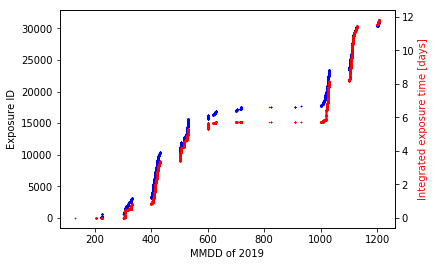

In [11]:
plt.plot(allexps['night'] - 20190000, allexps['id'], 'b.', ms=1)
plt.xlabel('MMDD of 2019')
plt.ylabel('Exposure ID')
rhs = plt.twinx()
rhs.plot(allexps['night'] - 20190000, np.cumsum(allexps['exptime']) / 86400, 'r.', ms=1)
rhs.set_ylabel('Integrated exposure time [days]', color='r')
plt.grid(axis='x');

There are also utility classes (described below) for easier and more efficient interaction with the table of exposures and the various tables of continuously recorded "telemetry" conditions (temperatures, voltages, etc).

## Exposures Database

The `Exposures` class allows you to look up all the information available about any exposure using its ID number (including all exposures from the Spring 2019 CI run). It also remembers the exposures it has already fetched from the database, to avoid unnecessary queries:

In [12]:
ExpInfo = Exposures(db)

List all of the columns available for each exposure:

In [13]:
', '.join(sorted(ExpInfo.columns))

'aborted, action, adc, airmass, aos, built, cal_lamps, collected, computer, data_location, date_obs, decoffset, deltadec, deltara, digitized, digitizing, discard, distributed, dome, domeaz, dominpos, done, errors, etc, excluded, exposed, exposing, exptime, fiberassign, flavor, focstime, focus, focus_cameras, frames, guide_cameras, guider, guider_mode, guidoffd, guidoffr, guidtime, hexapod, hexapod_time, id, image_cameras, inctrl, inpos, inposition, instance, lead, manifest, mjd_obs, mntoffd, mntoffr, moonangl, moondec, moonra, mountaz, mountel, mountha, multiframe, night, ntargets, object, observers, obstype, parallactic, paused, petals, pmready, positer, positioned, prepared, program, propid, raoffset, readout_time, reqaz, reqdec, reqel, reqha, reqra, reqtime, s2n, saved, saved_updated, script, se_annex, seeing, seqid, seqnum, seqtot, sequence, skydec, skylevel, skyra, skytime, slew_time, slewangl, spectrographs, st, started, targtdec, targtra, tcsmjd, telescope, telstat, thumbnail, t

For example, to lookup which night a particular exposure was taken, use:

In [14]:
ExpInfo(20000, 'night')

20191022

## Telemetry Database

The `NightTelemetry` class allows you to examine the data recorded in any of the telemetry tables listed [here](http://web.replicator.dev-cattle.stable.spin.nersc.org:60040/TV3/app/T/index).  For example, to study the temperature of the GFA CCDs:

In [15]:
gfa_telemetry = desietcimg.db.NightTelemetry(db, 'gfa_telemetry')

Telemetry requests are indexed by the observing night (and previously fetched nights are cached for efficiency):

In [16]:
gfa_night = gfa_telemetry(20191027)

In [17]:
', '.join(list(gfa_night.columns))

'gfa_telemetry, last_updated, status, ccdpower, ambient, unit, role, settemp, time_recorded, dos_instance, row_status, row_status_time, row_status_user, ccdtemp, cooling, hotpeltier, coldpeltier, filter, humid2, humid3, fpga, camerahumid, cameratemp, MJD'

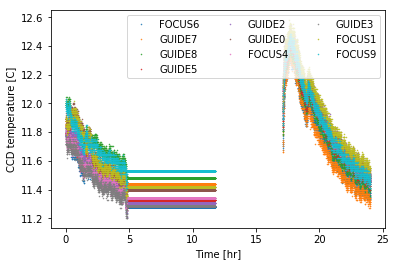

In [18]:
MJD0 = gfa_night['MJD'][0]
for gfa in gfa_night['role'].unique():
    sel = gfa_night['role'] == gfa
    plt.plot(24 * (gfa_night[sel]['MJD'] - MJD0), gfa_night[sel]['ccdtemp'], '.', ms=1, label=gfa)
plt.legend(loc='upper right', ncol=3)
plt.xlabel('Time [hr]')
plt.ylabel('CCD temperature [C]');

As another example, look up the ADC angles during a night:

In [19]:
adc_telemetry = desietcimg.db.NightTelemetry(db, 'adc_controllers')

In [20]:
adc_night = adc_telemetry(20191112)

Check which DOS instances were logging ADC telemetry on this night (in case there is simulated data mixed with real data):

In [21]:
adc_night['dos_instance'].unique()

array(['commish_20191111', 'commish_20191112'], dtype=object)

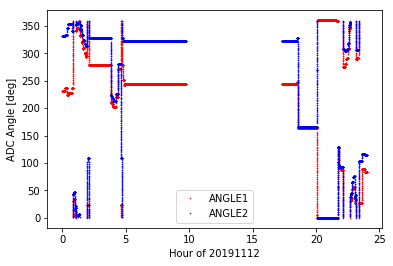

In [22]:
MJD0 = adc_night['MJD'][0]
plt.plot((adc_night['MJD'] - MJD0) * 24, adc_night['angle1'], 'r.', ms=1, label='ANGLE1')
plt.plot((adc_night['MJD'] - MJD0) * 24, adc_night['angle2'], 'b.', ms=1, label='ANGLE2')
plt.legend()
plt.xlabel('Hour of 20191112')
plt.ylabel('ADC Angle [deg]');